# Set Up

In [ ]:
from nltk import ngrams
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
torch.manual_seed(1)

In [ ]:
if torch.cuda.is_available():
    dev = "cuda:0" 
else:
    dev = "cpu"  
device = torch.device(dev)
print(device)

cuda:0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

In [ ]:
!wget https://the-eye.eu/public/AI/pile_preliminary_components/books1.tar.gz
!tar -xf books1.tar.gz
path = 'books1/epubtxt/'
selected_book = 'crocodiles-spirit.epub.txt'

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize,word_tokenize

!pip3 install pytorch-nlp
from torchnlp.word_to_vector import GloVe
glove = GloVe(name='6B', dim='50')

from tqdm.notebook import tqdm
import numpy as np
import re

--2021-04-29 13:33:56--  https://the-eye.eu/public/AI/pile_preliminary_components/books1.tar.gz
Resolving the-eye.eu (the-eye.eu)... 162.213.130.242
Connecting to the-eye.eu (the-eye.eu)|162.213.130.242|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2404269430 (2.2G) [application/octet-stream]
Saving to: ‘books1.tar.gz’

books1.tar.gz       100%[===================>]   2.24G  17.0MB/s    in 2m 21s  

2021-04-29 13:36:18 (16.3 MB/s) - ‘books1.tar.gz’ saved [2404269430/2404269430]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 92kB 3.6MB/s 


glove.6B.zip: 862MB [02:42, 5.29MB/s]                           
100%|██████████| 400000/400000 [00:24<00:00, 16498.59it/s]


In [ ]:
class Dictionary():
    def __init__(self, words=None, th=10):
        if not words is None:
            self.fit(words, th)

    def calc_wordfreqs(self):
        self.wordfreqs   = {}
        for word in self.words:
            if word in self.wordfreqs:
                self.wordfreqs[word] += 1
            else:
                self.wordfreqs[word]  = 1
    
    def set_vocabs(self, th):
        self.vocabs = set(["<s>", "</s>", "<unk>"])
        for word in self.words:
            if self.wordfreqs[word] >= th:
                self.vocabs.add(word)

    def set_idx_word_map(self):
        self.word_to_idx = {}
        self.idx_to_word = {}
        for idx, word in enumerate(self.vocabs):
            self.idx_to_word[idx] = word
            self.word_to_idx[word] = idx

    def to_idx(self, word):
        return self.word_to_idx[self.__getitem__(word)]
    
    def to_word(self, idx):
        return self.idx_to_word[idx]

    def to_idxs(self, words):
        return [self.to_idx(word) for word in words]
    
    def to_words(self, idxs):
        return [self.to_word(idx) for idx in idxs]

    def fit(self, words, th=10):
        self.words = words
        self.calc_wordfreqs()
        self.set_vocabs(th)
        self.set_idx_word_map()

    def transfer(self, words):
        return [self.__getitem__(word) for word in words]
    
    def __len__(self):
        return len(self.vocabs)

    def __getitem__(self, word):
        if word in self.vocabs:
            return word
        else:
            return "<unk>"


class MyPreprocessor():
    def __init__(self):
        self.sent_start  = "<s>"
        self.sent_end    = "</s>"
        self.unk         = "<unk>"
        self.dictionary  = None


    def sent_tokenize(self, document):
        sents = sent_tokenize(document)
        return sents

    def word_tokenize(self, sents):
        words = []
        for sent in sents:
            words.append(self.sent_start)
            words += word_tokenize(sent)
            words.append(self.sent_end)
        return words

    def tokenize(self, document):
        sents = self.sent_tokenize(document)
        words = self.word_tokenize(sents)
        return words

    def lower(self, words):
        return [word.lower() for word in words]

    def prep(self, book):
        document = re.sub(r"[^a-zA-Z0-9'!?;\.]", r" ", book)
        words = self.tokenize(document)
        words = self.lower(words)
        return words
    
    def fit(self, document):
        words = self.prep(document)
        self.dictionary = Dictionary(words)

    def transfer(self, document):
        words = self.prep(documents)
        return self.dictionary.transfer(words)

    def fit_transfer(self, document):
        words = self.prep(document)
        self.dictionary = Dictionary(words)
        return self.dictionary.transfer(words)
        

In [ ]:
with open(path+selected_book) as f:
  book = f.read()

In [ ]:
book

' \nCrocodile\'s Spirit\n\nCrocodile Dreaming - Books 1 and 2\n\nSecond Edition Box Set\n\nGraham Wilson\n\nCopyright\n\nCrocodile\'s Spirit\n\nGraham Wilson\n\nCopyright Graham Wilson 2017\n\nBeyondBeyond Books Edition\n\nPublished by Smashwords\n\nISBN: 9781370059348\n\nSmashwords Edition Licence Notes\n\nThis ebook is licensed for your personal enjoyment only. This ebook may not be re-sold or given away to other people. If you would like to share this book with another person, please purchase an additional copy for each recipient. If you\'re reading this book and did not purchase it, or it was not purchased for your use only, then please return to Smashwords.com and purchase your own copy. Thank you for respecting the hard work of this author.\n\nAll rights reserved. No part of this book may be reproduced or transmitted in any form without prior approval of the author.\n\nFor permission to use contact Graham Wilson by email at grahambbbooks@gmail.com\n\n_An English Visitor_\n\nBook 

In [ ]:
prep = MyPreprocessor()
prep.fit(book)

In [ ]:
len(prep.dictionary)

1644

In [ ]:
class NGramDS(Dataset):
    def __init__(self, n, dictionary):
        super().__init__()
        self.n = n
        self.dictionary = dictionary
        self.grams = ngrams(self.dictionary.words, self.n)
        self.X = []
        self.Y = []
        for gram in self.grams:
            self.X.append(self.dictionary.to_idxs(list(gram[0:-1])))
            self.Y.append(self.dictionary.to_idx(gram[-1]))

        self.X = torch.tensor(self.X, dtype=torch.long)
        self.Y = torch.tensor(self.Y, dtype=torch.long)

    def __len__(self):
        return len(self.X)
        

    def __getitem__(self, i):
        return (self.X[i], self.Y[i])

In [ ]:
class FFNLM(nn.Module):
    def __init__(self, V, embed_dim, n):
        super().__init__()
        self.V = V
        self.embed_dim = embed_dim
        self.n = n

        self.embed = nn.Embedding(self.V, self.embed_dim)
        self.lin1  = nn.Linear(self.embed_dim*self.n, 1024)
        self.lin2  = nn.Linear(1024, self.V)

    def forward(self, x):
        x = self.embed(x).view(-1, self.embed_dim*self.n)
        x = torch.tanh(self.lin1(x))
        x = torch.tanh(self.lin2(x))
        return x


In [ ]:
EMBEDDING_DIM = 100
CONTEXT_SIZE = 5

model = FFNLM(len(prep.dictionary), EMBEDDING_DIM , CONTEXT_SIZE-1)
model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [ ]:
BATCH_SIZE = 128
ds = NGramDS(CONTEXT_SIZE, prep.dictionary)
dl = DataLoader(ds, batch_size=BATCH_SIZE ,shuffle=True, num_workers=2)

In [ ]:
losses = []

In [ ]:
EPOCHS = 80

In [ ]:
for epoch in range(EPOCHS):
    for X, Y in tqdm(dl, desc=f'epoch = {epoch+1}/{EPOCHS}'):
        X = X.to(device)
        Y = Y.to(device)

        model.zero_grad()
        O = model(X)
        loss = loss_function(O, Y)
        loss.backward()
        optimizer.step()

        # creat log
        losses.append(loss.item())


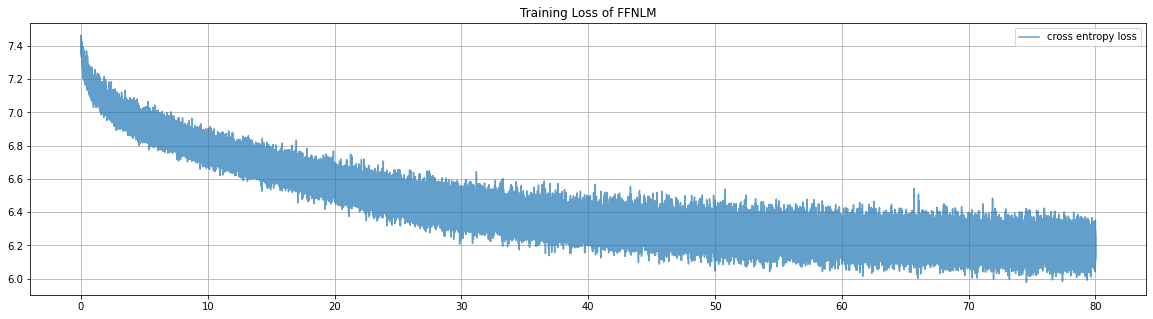

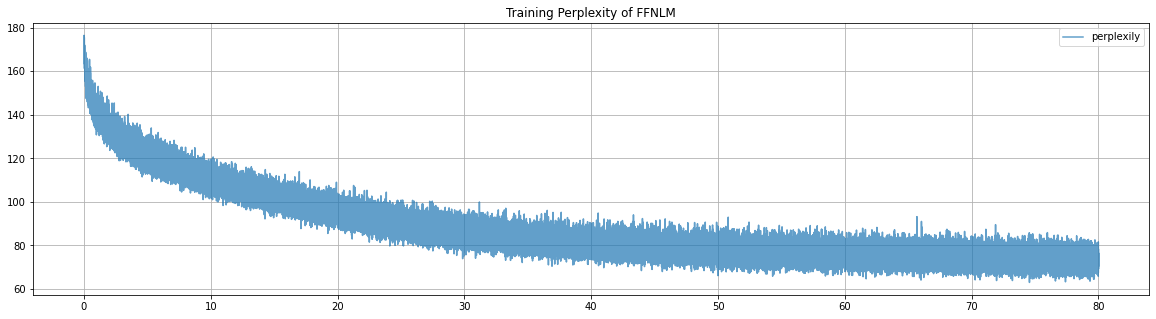

In [ ]:
plt.figure(figsize=(20, 5))
x = np.linspace(0, EPOCHS, len(losses))
plt.plot(x,losses, label='cross entropy loss', alpha=0.7)
plt.grid()
plt.title('Training Loss of FFNLM')
plt.legend()

plt.figure(figsize=(20, 5))
plt.plot(x, [np.power(2, l) for l in losses], label='perplexily', alpha=0.7)
plt.grid()
plt.title('Training Perplexity of FFNLM')
plt.legend()

## generate new sentences

In [ ]:
sentence = ["<s>", "thank", "you", "for"]
new_word = "TEMP"
while not (new_word == "</s>" or new_word == "."):
    idxs = torch.tensor(prep.dictionary.to_idxs(sentence[-CONTEXT_SIZE+1::]), dtype=torch.long, device=device).view(1, -1)
    probs = F.softmax(model(idxs)).view(-1).detach().cpu().numpy()
    next_idx = random.choices(range(len(probs)), weights=probs)
    next_word = prep.dictionary.to_word(next_idx[0])
    if not next_word == "<unk>":
        sentence.append(next_word)
    if len(sentence)>10: break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


In [ ]:
" ".join(sentence)

'<s> thank you for wanting blood buried hair was dream city'